# Logistic Regression

Why do we call it a 'regression' when this is actually a classifier? The idea is that the regression doesnt output a class label, but probabilities indicating how likely the output has a label, and is good at **binary classification** based on features.

In the case of an image of some animal, which could either be a cat or not a cat. Say: $cat = 1, !cat = 0$.

Logistic regression works on binary classification, and produces a value $p\in [0,1]$

---

Say we have $n$ features in a feature vector $\mathbf{X}$, so each feature is $X_j^{(i)}$, and we have $m$ instances.

We take these $\mathbf{X}^{(i)}$ and a parameter matrix (weights and biases, ordinary linear regression) $\Theta\rightarrow \Theta^T\mathbf{X}^{(i)}=\mathbf{Z}^{(i)}$, a set of outputs - the logits.

For each feature, we have $n$ parameters. This is implied through linear algebra. Our goal is to find $\Theta$ using gradient descent and optimisation.

---

We need to find a function with a codomain of $f(x)\in(0,1)$. This is the sigmoid function.

$\phi(z) = \frac 1{1 + e^{-z}}$

This allows us to get to this:

$h_\Theta ^{(i)}\left( \mathbf{X}^{(i)} \right) = \phi\left(\mathbf{Z}^{(i)}\right)$

Where $h$ is the estimated probability. We need a function we can optimise now, and we think about this through a **likelihood** approach.

$\mathcal{L}\left(\Theta\right)=\prod_{i=1}^m \left[ h_\Theta ^{(i)}\left( \mathbf{X}^{(i)} \right) \right]^{y^{(i)}}\left[ 1-h_\Theta ^{(i)}\left( \mathbf{X}^{(i)} \right) \right]^{1-y^{(i)}}$

In [1]:
# say that the sigmoid function produced 0.999, and it is correct (ie. y=1)

print(0.999**1 * (1-0.999)**0)

0.999


In [2]:
# what about if sigmoid produces 0.999 but y=0?

print(0.999**0 * (1-0.999)**1)

0.0010000000000000009


## Loss function

If we get things right, we get numbers close to the sigmoid, and if we are wrong, the likelihood gets reduced.

There are a few faults though.
1. we need to negate the likelihood so that we can perform gradient descent, we want a loss function. So, we are going to minimise $\mathcal{L}^{-1}$
2. its numerically unstable, so we want to take $\ln$ too. $\rightarrow \ln{\mathcal{L}}$
3. We also want to divide by the number of instances, since logging the likelihood will turn it into a sum. $\rightarrow \frac1m\times\cdots$

$\Longrightarrow \ln{\mathcal{L}}=\sum_{i=1}^m {y^{(i)}\ln{h_\Theta (\mathbf{x}^{(i)})} + (1-y^{(i)})\ln{\left(1-h_\Theta (\mathbf{x}^{(i)})\right)}}$ is the log-likelihood. Applying the next two, armed with the logarithm laws:

1. $\ln{\left( a\cdot b \right)} = \ln a + \ln b$
2. $\ln {\left( a^b \right)}=b\ln a$

$
\Longrightarrow \mathcal{J}(\Theta)=-\frac1m \sum_{i=1}^m \left[{y^{(i)}\ln{h_\Theta (\mathbf{x}^{(i)})} + (1-y^{(i)})\ln{\left(1-h_\Theta (\mathbf{x}^{(i)})\right)} }\right]
$

This is called the "cross-entropy **loss function**". It's the negative average log likelihood, and it is also what we want to minimise when performing gradient descent.

---

## Gradient Descent

We have our parameters, $\Theta$. For each $\Theta_j$, how much does it have to change for the answer to be correct? How do we adjust the parameters to minimise the loss function?

We have $n$ features, so $n$ parameters, one for each feature.

$
\frac{\partial (\ln{\mathcal{L}})}{\partial \Theta_j} = \frac{\partial (\ln{\mathcal{L}})}{\partial h}\frac{\partial h}{\partial z}\frac{\partial z}{\partial \Theta_j}
$

The individual factors can be simplified, and was done on paper.

$
\longrightarrow \frac{\partial (\ln{\mathcal{L}})}{\partial \Theta_j} = \left[ \frac yh - \frac{1-y}{1-h} \right]\left[ h(1-h) \right]\mathbf{x}_j^{(i)} = (y-h)\mathbf{x}_j^{(i)}
$

$
\Longrightarrow \frac{\partial \mathcal{J}}{\partial \Theta_j} = -\frac{1}m (y^{(i)}-h)\mathbf{x}_j^{(i)}
$

We are interested in the vector form of this.

$
\nabla_\Theta \mathcal{J}(\Theta) = \frac1m \mathbf{X}^T\left( \mathbf{y}-h(\Theta X)\right)
$

With a learning rate $\alpha$, we take $\Theta\rightarrow\Theta-\alpha\cdot\nabla_\Theta \mathcal{J}(\Theta)$ in order to minimise our loss function.

In [3]:
# implement the important functions
import numpy as np

def sigmoid(z) -> float: # the sigmoid function
    return 1 / (1 + np.exp(-z))

def gradient(Theta, X, y) -> np.ndarray: # calculate the gradient for gradient descent
    return (X.T @ (sigmoid(X @ Theta) - y)) / y.size

def gradient_descent(X, y, alpha=0.1, num_iterations=200, tol=1e-7) -> np.ndarray:
    # appending a column of ones for each feature
    # note: this is, in effect, the "intercept" bias, much like in the linear regression algorithm
    X_bias = np.c_[np.ones((X.shape[0], 1)), X]
    Theta = np.zeros(X_bias.shape[1])

    for i in range(num_iterations):
        grad = gradient(Theta, X_bias, y)
        Theta -= alpha * grad

        # check for tolerance
        if np.linalg.norm(grad) < tol:
            print("Tolerance hit, stopping gradient descent")
            break

    return Theta

---

## Predictions

Create functions to predict based on data. These prediction functions will train on $\mathbf{X}$, and predict the probability of a scenario between zero and one. We can say that most of the time, a prediction is likely to be taken as whether the probability is above or below **50\%** (hence the 'threshold' parameter). We return the **boolean** as an **integer** since we want the model to make a decision for us. 

Taking the example from earlier, if we have an animal that is 43\% cat, we need the model to make a decision, the prediction cannot be drenched in ambiguity. One would sensibly say that an animal that a model sees as 43\% cat is likely not a cat, and will get a label of $0$, whereas a probability of 88\% is given a label of $1$.

In [ ]:
def predict_probs(X, Theta): # no need to specify type, already in the sigmoid function
    X_bias = np.c_[np.ones((X.shape[0], 1)), X]
    return sigmoid(X_bias @ Theta)

def predict(X, Theta, threshold=0.5): # here, type is asserted in the "astype" method
    # we will return predictions as an integer
    return (predict_probs(X, Theta) >= threshold).astype(int)

---

## Performance evaluation

We will use scikit-learn's breast cancer dataset to test the logistic regression model. The following cell is where the youtube video will leave things off:

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score # just a simple evaluation

# Random seed for reproducibility
R = 260725 # date today is 26/7/25, fun

# simple preprocessing, the data is nice
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=R)

scaler = StandardScaler()

# scale the data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# test the model
Theta_hat = gradient_descent(X_train, y_train, alpha=0.1, num_iterations=400)

y_pred_train = predict(X_train, Theta_hat)
y_pred_test = predict(X_test, Theta_hat)

training_accuracy = accuracy_score(y_train, y_pred_train)
testing_accuracy = accuracy_score(y_test, y_pred_test)

print("Training accuracy:", training_accuracy, "\n", "Testing accuracy:", testing_accuracy)

Training accuracy: 0.9846153846153847 
 Testing accuracy: 0.9736842105263158


This is a promising result, but we should test against scikit-learn LogisticRegressor: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [17]:
from sklearn.linear_model import LogisticRegression

# Use the same preprocessed data from before:
# X_train, y_train, X_test, y_test

# keep parameters the same
sk_LR = LogisticRegression(random_state=R, max_iter=200).fit(X_train, y_train)
sk_y_pred_train = sk_LR.predict(X_train)
sk_y_pred_test = sk_LR.predict(X_test)

sk_training_accuracy = accuracy_score(y_train, sk_y_pred_train)
sk_testing_accuracy = accuracy_score(y_test, sk_y_pred_test)

print("Training accuracy (sklearn):", sk_training_accuracy, "\n", "Testing accuracy (sklearn):", sk_testing_accuracy)

Training accuracy (sklearn): 0.989010989010989 
 Testing accuracy (sklearn): 0.9824561403508771


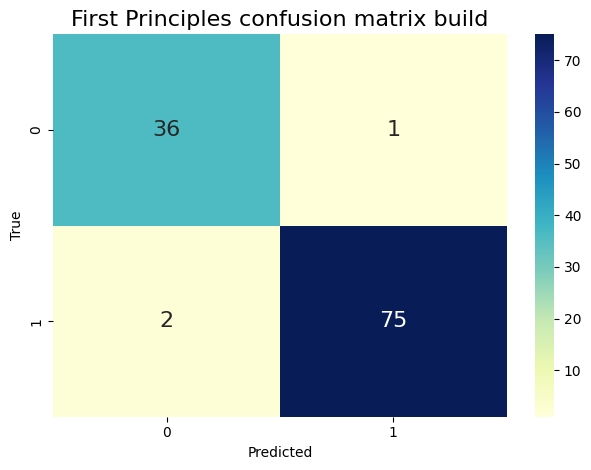

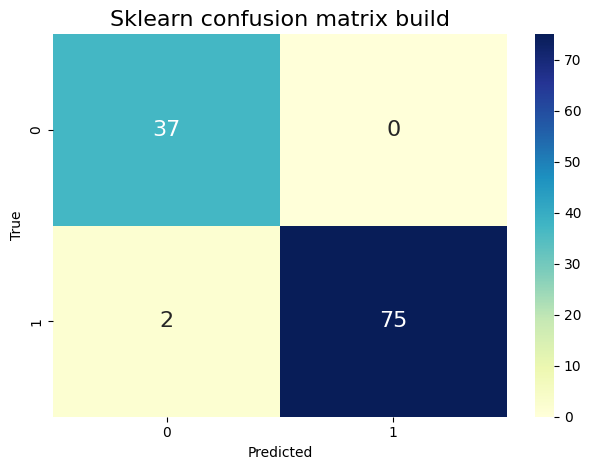

In [25]:
# take a look at each model in a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap="YlGnBu", annot_kws={"fontsize": 16})
plt.title("First Principles confusion matrix build", fontsize=16)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

sns.heatmap(confusion_matrix(y_test, sk_y_pred_test), annot=True, cmap="YlGnBu", annot_kws={"fontsize": 16})
plt.title("Sklearn confusion matrix build", fontsize=16)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

---

## Conclusion

It seems the only difference between the models was that single false positive that the sklearn wasn't fooled by, and resulted in a differing true accuracy score of $< 1\%$. As a proof of concept, the logistic regressor works negligibly similar to the standard scikit-learn package used as standard.

The next steps of this project are to research optimisation strategies that avoid computational cost, poor scalability or other additional risk.